In [1]:
import pandas as pd
import numpy as np
from tensorflow import keras
from BinanceCollector import BinanceCollector
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import datetime

c:\Users\deves\AppData\Local\Programs\Python\Python37\lib\site-packages\requests\__init__.py:114: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (5.0.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  RequestsDependencyWarning,


In [74]:
collector = BinanceCollector("ETHUSDT","2022-01-01","2022-12-31","1m")
collector.start_collect()
collector.df.columns = ["Open Time","Open","High","Low","Close","Volume","Close Time",
             "Quote asset volumne","Total Trades","Buyer Base Volume",
             "Taker buy quote asset volume","Ignore"]
df = collector.df
df["Next"] = df["Close"].shift(-3)
df.dropna(inplace=True)
std = df.std()
mean = df.mean()
df=(df-df.mean())/df.std()

In [75]:
df.tail()

,Open Time,Open,High,Low,Close,Volume,Close Time,Quote asset volumne,Total Trades,Buyer Base Volume,Taker buy quote asset volume,Ignore,Next
523788,1.732016,-1.022119,-1.022996,-1.021008,-1.021833,-0.519428,1.732016,-0.576243,-0.604023,-0.486156,-0.541561,NaN,-1.021967
523789,1.732023,-1.021835,-1.022996,-1.020725,-1.021833,-0.497588,1.732023,-0.560508,-0.651550,-0.525845,-0.570124,NaN,-1.021980
523790,1.732029,-1.021835,-1.022996,-1.020996,-1.021974,-0.507066,1.732029,-0.567340,-0.591515,-0.471628,-0.531108,NaN,-1.021143
523791,1.732036,-1.021964,-1.023125,-1.020854,-1.021974,-0.553458,1.732036,-0.600756,-0.676565,-0.521524,-0.567014,NaN,-1.020834
523792,1.732043,-1.021964,-1.022649,-1.021305,-1.021987,0.164834,1.732043,-0.083400,-0.412662,0.716331,0.323772,NaN,-1.020550


In [76]:
x = np.array(df[["Open","High","Low","Close","Volume"]])
y = np.array( df["Next"] )

In [77]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.25)
x_train = np.reshape(x_train,(x_train.shape[0],1,x_train.shape[1]))
x_test = np.reshape(x_test,(x_test.shape[0],1,x_test.shape[1]))

In [78]:
model = keras.Sequential([
    keras.layers.Dense(10,input_shape=(1,5),activation="relu" ),
    keras.layers.LSTM(8),
    keras.layers.Dense(8, activation="relu"),
    keras.layers.Dense(1)
])
model.compile(optimizer="adam",
                loss="mape",
                metrics=["mse"],
                )

log_dir = "logs\\fit\\" + "Devesh-TEst"
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [79]:
model.fit(x_train,y_train,epochs=5,callbacks=[tensorboard_callback])

Train on 392844 samples
Epoch 1/5
392844/392844 [==============================] - 79s 202us/sample - loss: 143.5196 - mean_squared_error: 0.0124
Epoch 2/5
392844/392844 [==============================] - 73s 186us/sample - loss: 29.1567 - mean_squared_error: 0.0015
Epoch 3/5
392844/392844 [==============================] - 68s 173us/sample - loss: 16.0206 - mean_squared_error: 8.8409e-04
Epoch 4/5
392844/392844 [==============================] - 72s 184us/sample - loss: 7.5046 - mean_squared_error: 4.8761e-04
Epoch 5/5
392844/392844 [==============================] - 24s 62us/sample - loss: 8.2435 - mean_squared_error: 7.0208e-04


In [80]:
model.evaluate(x_test,y_test)

130949/130949 [==============================] - 4s 28us/sample - loss: 44.1117 - mean_squared_error: 2.4199e-04


[44.11165746635198, 0.00024199164]

In [81]:
x_pred = np.reshape( x,(x.shape[0],1,x.shape[1]) )

In [82]:
y_pred = np.reshape(model.predict(x_pred),(y.shape[0]))
df = df*std + mean

In [83]:
df["Preds"] = y_pred*std["Next"] + mean["Next"]

<AxesSubplot:>

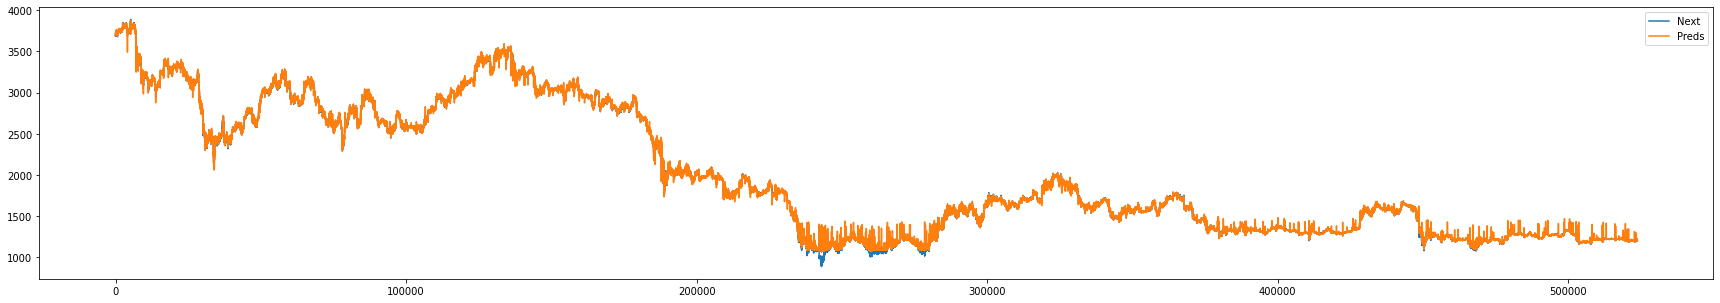

In [92]:
df[["Next","Preds"]].plot(figsize=(15*2,5))

In [86]:
# df = (df*std) + mean
df["Change"] = (df["Next"]-df["Close"])*100/df["Close"]
df["Change Pred"] = (df["Preds"]-df["Close"])*100/df["Close"]
df["Open Time"] = pd.to_datetime(df["Open Time"],unit="ms")
df["Close Time"] = pd.to_datetime(df["Close Time"],unit="ms")
df

,Open Time,Open,High,Low,Close,Volume,Close Time,Quote asset volumne,Total Trades,Buyer Base Volume,Taker buy quote asset volume,Ignore,Next,Preds,Change,Change Pred
0,2022-01-01 00:01:00,3684.85,3694.20,3681.33,3691.55,273.0180,2022-01-01 00:01:59.999,1.006818e+06,580.0,181.6745,670095.912422,NaN,3690.09,3698.564697,-0.039550,0.190020
1,2022-01-01 00:02:00,3692.50,3694.42,3687.49,3693.62,216.0824,2022-01-01 00:02:59.999,7.976563e+05,460.0,80.1555,295925.007905,NaN,3698.64,3699.272949,0.135910,0.153046
2,2022-01-01 00:03:00,3693.63,3695.41,3689.55,3690.58,250.2232,2022-01-01 00:03:59.999,9.237721e+05,448.0,109.0924,402765.079850,NaN,3705.14,3698.975586,0.394518,0.227487
3,2022-01-01 00:04:00,3690.57,3691.03,3688.00,3690.09,119.8314,2022-01-01 00:04:59.999,4.421674e+05,279.0,55.1763,203588.562778,NaN,3698.34,3696.365479,0.223572,0.170063
4,2022-01-01 00:05:00,3690.12,3698.96,3686.70,3698.64,242.3607,2022-01-01 00:05:59.999,8.950811e+05,564.0,134.0212,494979.783549,NaN,3696.46,3704.215820,-0.058941,0.150753
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
523788,2022-12-30 23:52:00,1198.78,1199.00,1198.77,1199.00,38.4236,2022-12-30 23:52:59.999,4.606728e+04,145.0,21.9620,26330.130320,NaN,1198.89,1197.997681,-0.009174,-0.083596
523789,2022-12-30 23:53:00,1199.00,1199.00,1198.99,1199.00,57.5084,2022-12-30 23:53:59.999,6.895203e+04,107.0,3.6695,4399.730500,NaN,1198.88,1198.126221,-0.010008,-0.072876
523790,2022-12-30 23:54:00,1199.00,1199.00,1198.78,1198.89,49.2261,2022-12-30 23:54:59.999,5.901643e+04,155.0,28.6573,34355.759846,NaN,1199.53,1198.037354,0.053383,-0.071120
523791,2022-12-30 23:55:00,1198.90,1198.90,1198.89,1198.89,8.6869,2022-12-30 23:55:59.999,1.041469e+04,87.0,5.6612,6787.212680,NaN,1199.77,1197.904297,0.073401,-0.082218


In [88]:
# df[["Open","High","Low","Close","Volume"]]
x = np.array([[1,2,3,4,5]])
x = np.reshape(x,(1,1,5))

In [89]:
model.predict(x)

array([[3.1975467]], dtype=float32)

In [93]:
len(df[ df["Change"]*df["Change Pred"] >= 0 ]) / len(df)

0.5009230745733525